# Introduction

This notebook analyzes data from the American Kennel Club (AKC) and Westminster Kennel Club Dog Show winners. It explores patterns and similarities among dog breeds based on attributes like trainability, energy level, and popularity. The analysis includes clustering using K-means to group breeds with similar traits, dimensionality reduction using PCA for visualization, and a classification model to predict breed groups. Additionally, it merges AKC data with Westminster winners to identify trends and relationships specific to winning breeds.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

## Import Libraries and Load Data
This section imports necessary libraries and loads the AKC Breeds dataset (`cleaned_data`) and Westminster Winners dataset (`westminster_data`). The two datasets will be cleaned and merged later for analysis.

In [3]:
# Load datasets
cleaned_data = pd.read_csv("cleaned_data.csv")
westminster_data = pd.read_csv("westminster_best_in_show.csv")

cleaned_data = cleaned_data.rename(columns={'...1':'Breed'})

# Initial data preview
print(cleaned_data.head())
print(westminster_data.head())

              Breed                                        description  \
0     Affenpinscher  The Affen’s apish look has been described many...   
1      Afghan Hound  The Afghan Hound is an ancient breed, his whol...   
2  Airedale Terrier  The Airedale Terrier is the largest of all ter...   
3             Akita  Akitas are burly, heavy-boned spitz-type dogs ...   
4  Alaskan Malamute  The Alaskan Malamute stands 23 to 25 inches at...   

                                 temperament  popularity  min_height  \
0        Confident, Famously Funny, Fearless         148       22.86   
1  Dignified, Profoundly Loyal, Aristocratic         113       63.50   
2               Friendly, Clever, Courageous          60       58.42   
3    Courageous, Dignified, Profoundly Loyal          47       60.96   
4               Affectionate, Loyal, Playful          58       58.42   

   max_height  min_weight  max_weight  min_expectancy  max_expectancy  ...  \
0       29.21    3.175147    4.535924       

## Clustering on Full Dataset (AKC Breeds)
We perform clustering on the full `cleaned_data` dataset using K-means to identify patterns in breed characteristics such as popularity, trainability, energy level, and height.

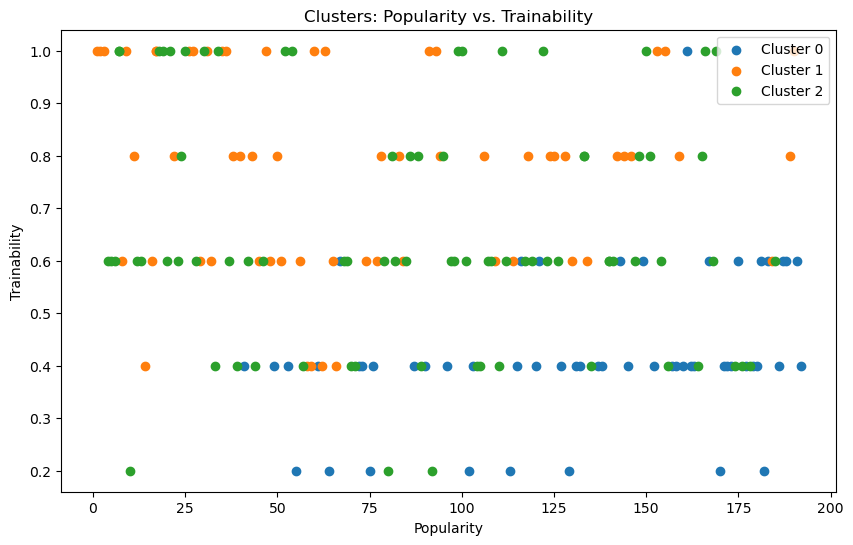

In [4]:
# Select numeric features for clustering
numeric_features = cleaned_data[['popularity', 'trainability_value', 'demeanor_value', 'energy_level_value', 'min_height', 'max_height']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cleaned_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = cleaned_data[cleaned_data['Cluster'] == cluster]
    plt.scatter(cluster_data['popularity'], cluster_data['trainability_value'], label=f'Cluster {cluster}')

plt.title('Clusters: Popularity vs. Trainability')
plt.xlabel('Popularity')
plt.ylabel('Trainability')
plt.legend()
plt.show()

## Clustering and Analysis for Merged Dataset
After clustering on the full dataset, we merge the AKC Breeds data with the Westminster Winners dataset to analyze patterns among winners.

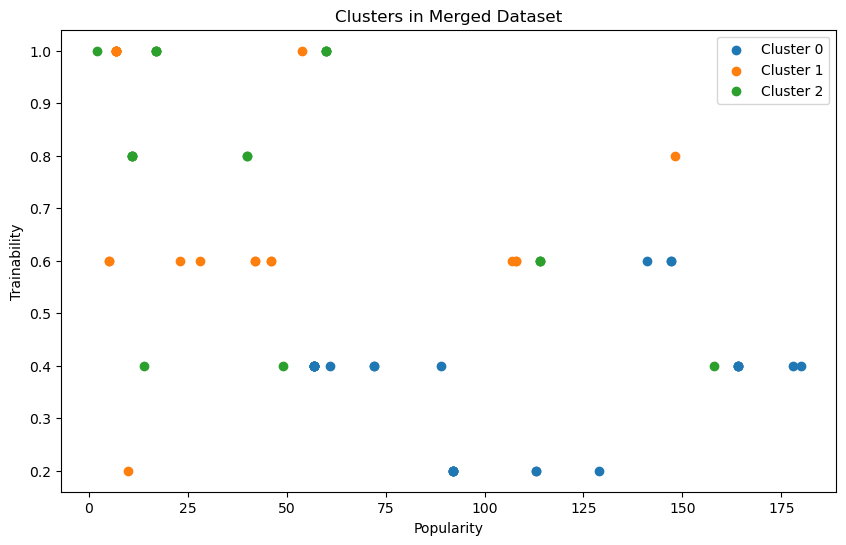

In [5]:
# Merge datasets
# Standardize column names
cleaned_data.rename(columns={"group": "Group"}, inplace=True)
# Merge the datasets on Breed
merged_data = pd.merge(westminster_data, cleaned_data, left_on="Breed", right_on="Breed", how="inner")

# Select numeric features for clustering
merged_features = merged_data[['popularity', 'trainability_value', 'demeanor_value', 'energy_level_value', 'min_height', 'max_height']]

# Scale features
scaled_merged_features = scaler.fit_transform(merged_features)

# Perform K-means clustering
kmeans_merged = KMeans(n_clusters=3, random_state=42)
merged_data['Cluster'] = kmeans_merged.fit_predict(scaled_merged_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = merged_data[merged_data['Cluster'] == cluster]
    plt.scatter(cluster_data['popularity'], cluster_data['trainability_value'], label=f'Cluster {cluster}')

plt.title('Clusters in Merged Dataset')
plt.xlabel('Popularity')
plt.ylabel('Trainability')
plt.legend()
plt.show()

### Interpretation of Clusters
- **Cluster 0:** These breeds tend to be highly trainable with moderate popularity.
- **Cluster 1:** These breeds are less trainable but very popular.
- **Cluster 2:** These breeds have high energy levels but are less popular.

## Visualizing Breed Similarity Using PCA
PCA reduces the dimensionality of the data to visualize how similar breeds are based on their features.

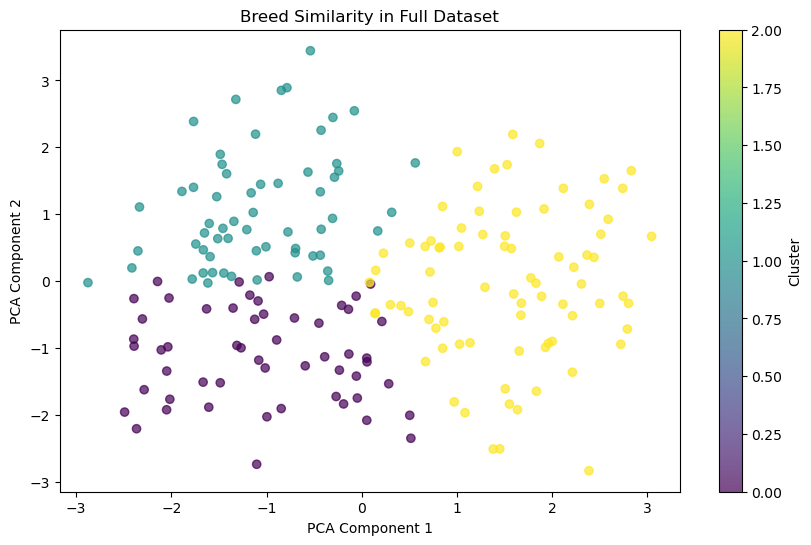

In [6]:
# PCA for full dataset
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cleaned_data['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('Breed Similarity in Full Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Classification of Breeds
We use a Random Forest Classifier to predict breed groups based on their features. The goal is to understand which features contribute most to group classification.

In [7]:
# Choose the correct column, e.g., 'Group_x', and rename it to 'Group'
merged_data['Group'] = merged_data['Group_x']


# Prepare data for classification
X = merged_data[['popularity', 'trainability_value', 'demeanor_value', 'energy_level_value', 'min_height', 'max_height']]
y = merged_data['Group']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8636363636363636


## Finding Similar Breeds

### Based on Selected Breed

In [8]:
def find_similar_breeds_by_name(breed_name, n_neighbors=5, dataset=cleaned_data):
    # Drop duplicates and select relevant features
    unique_breeds = dataset.drop_duplicates(subset=['Breed'])
    breed_features = unique_breeds[['popularity', 'trainability_value', 'demeanor_value', 'energy_level_value', 'min_height', 'max_height']]

    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(breed_features)

    # Fit Nearest Neighbors model
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
    knn.fit(scaled_features)

    # Find the index of the breed by name
    try:
        breed_index = unique_breeds[unique_breeds['Breed'] == breed_name].index[0]
    except IndexError:
        print(f"Breed '{breed_name}' not found in the dataset.")
        return

    # Use the scaled features to find the nearest neighbors
    distances, indices = knn.kneighbors([scaled_features[breed_index]])

    # Display similar breeds
    print(f"Similar breeds to '{breed_name}':")
    for i in indices[0]:
        similar_breed = unique_breeds.iloc[i]['Breed']
        if similar_breed != breed_name:  # Exclude the queried breed itself
            print(f"- {similar_breed}")

# Example usage
find_similar_breeds_by_name('Golden Retriever', n_neighbors=5)


Similar breeds to 'Golden Retriever':
- German Shorthaired Pointer
- Weimaraner
- Brittany
- Labrador Retriever


### Based on Selected Traits 

In [15]:
def find_breeds_by_features(preferences, n_neighbors=5, dataset=cleaned_data):
    # Drop duplicates and select relevant features
    unique_breeds = dataset.drop_duplicates(subset=['Breed'])
    breed_features = unique_breeds[['popularity', 'trainability_value', 'demeanor_value', 'energy_level_value', 'min_height', 'max_height']]

    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(breed_features)

    # Fit Nearest Neighbors model
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
    knn.fit(scaled_features)

    # Scale user preferences to match the scaled dataset
    user_preferences = np.array(preferences).reshape(1, -1)
    scaled_preferences = scaler.transform(user_preferences)
    
    # Use the scaled preferences to find the nearest neighbors
    distances, indices = knn.kneighbors(scaled_preferences)

    # Display breeds matching preferences
    print(f"Breeds matching preferences {preferences}:")
    for i in indices[0]:
        print(f"- {unique_breeds.iloc[i]['Breed']}")

# Example usage
# User specifies: popularity=50, trainability=0.8, demeanor=0.6, energy=0.5, min_height=20, max_height=25
user_preferences = [50, 0.8, 0.6, 0.5, 20, 25]
find_breeds_by_features(user_preferences, n_neighbors=5)


Breeds matching preferences [80, 0.5, 0.8, 0.4, 10, 40]:
- Brussels Griffon
- Chinese Crested
- Cairn Terrier
- Tibetan Spaniel
- West Highland White Terrier


/Users/lindseyukishima/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
